# Imports and dataset download

In [1]:
import csv
import torch 
import sklearn
import scipy
from scipy import io
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.utils.data as data
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment as linear_assignment
from typing import Optional
import seaborn as sns

import copy
import random
import time
from math import floor

import os


In [2]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

float_Tensor = torch.FloatTensor
if cuda: float_Tensor = torch.cuda.FloatTensor
	
drop_last = True
shuffle = False
IMG_SIZE = 28

In [3]:
def get_10x_73k(batch_size=64, data_points=-1):
    # Original Labels are within 0 to 9.
    # But proper label mapping is required as there are 8 classes.
    map_labels = {0: 0, 1: 1, 2: 2, 4: 3, 6: 4, 7: 5, 8: 6, 9: 7}
    notebook_path = os.path.abspath("10x_73k-clustering.ipynb")
    labels_path = os.path.join(os.path.dirname(notebook_path), "drive/MyDrive/Diploma/labels.txt")
    data_path = os.path.join(os.path.dirname(notebook_path),"drive/MyDrive/Diploma/sub_set-720.mtx")

    # Read data
    data = scipy.io.mmread(data_path)
    data = data.toarray()
    data = np.log2(data + 1)
    scale = np.max(data)
    data = data / scale
    total_size = data.shape[0]
    random_permutation = np.random.permutation(np.arange(total_size))
    data = data[random_permutation]
    data = np.float32(data)

    # Read labels
    labels = np.loadtxt(labels_path).astype(int)
    labels = labels[random_permutation]
    labels = np.array([map_labels[i] for i in labels])

    if (data_points > 0):
        data = data[:data_points]
        labels = labels[:data_points]

    # Convert to tensor dataset
    tensor_data = torch.Tensor(data)
    data_shape = data.shape[1]
    tensor_labels = torch.Tensor(labels)
    final_dataset = TensorDataset(tensor_data, tensor_labels)
    dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)

    return dataloader, data_shape, data, labels

In [4]:
dataloader, data_shape, datapoints, labels = get_10x_73k(batch_size=64, data_points=10000)

# Autoencoder/Custom dataset/function declarations

In [5]:
class CustomDataset(Dataset):
  def __init__(self, datapoints, labels, transform=None):

    self.datapoints = datapoints
    self.labels = labels
    self.transform = transform

  def __getitem__(self, index):
    sample = self.datapoints[index], self.labels[index]

    if self.transform:
      sample = self.transform(sample)

    return sample
  
  def __len__(self):
    return len(self.datapoints)

In [6]:
# TODO: search hungarian algorithm
def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
	"""
	Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
	determine reassignments.

	:param y_true: list of true cluster numbers, an integer array 0-indexed
	:param y_predicted: list of predicted cluster numbers, an integer array 0-indexed
	:param cluster_number: number of clusters, if None then calculated from input
	:return: reassignment dictionary, clustering accuracy
	"""
	if cluster_number is None:
		# assume labels are 0-indexed
		cluster_number = (max(y_predicted.max(), y_true.max()) + 1)
	count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
	for i in range(y_predicted.size):
		count_matrix[y_predicted[i], y_true[i]] += 1

	row_ind, col_ind = linear_assignment(count_matrix.max() - count_matrix)
	reassignment = dict(zip(row_ind, col_ind))
	accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
	return reassignment, accuracy

def transform_clusters_to_labels(clusters, labels):
	# Find the cluster ids (labels)
	c_ids = np.unique(clusters)

	# Dictionary to transform cluster label to real label
	dict_clusters_to_labels = dict()

	# For every cluster find the most frequent data label
	for c_id in c_ids:
		indexes_of_cluster_i = np.where(c_id == clusters)
		elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
		true_label_index = np.argmax(frequency)
		true_label = elements[true_label_index]
		dict_clusters_to_labels[c_id] = true_label

	# Change the cluster labels to real labels
	for i, element in enumerate(clusters):
		clusters[i] = dict_clusters_to_labels[element]

	return clusters



In [7]:
def check_number_of_representatives(Y): # TODO: check for empty clusters
  cluster_map = {}

  for element in Y:
    if element not in cluster_map:
      cluster_map[element] = 1
    else:
      cluster_map[element] += 1

  for cluster_number in cluster_map.keys():
    print("Cluster", cluster_number, ":", cluster_map[cluster_number], "elements \n")

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, input_dimension, hl1_neurons, hl2_neurons, latent_dimension):
        super().__init__()

        # Encoder Model
        self.input_dimension = input_dimension
        self.hl1_neurons = hl1_neurons
        self.hl2_neurons = hl2_neurons
        self.latent_dimension = latent_dimension

        self.encoder_model = nn.Sequential(
          nn.Linear(input_dimension, self.hl1_neurons),
          # nn.ReLU(inplace=True),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, self.hl2_neurons),
          # nn.ReLU(inplace=True),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
        )
        
        # Latent Space
        self.latent_space = nn.Sequential(
          nn.Linear(self.hl2_neurons, self.latent_dimension),
          # nn.ReLU(inplace=True),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.latent_dimension),
        )

        # Decoder Model
        self.decoder_model = nn.Sequential(
          nn.Linear(self.latent_dimension, self.hl2_neurons),
          # nn.ReLU(inplace=True),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
          nn.Linear(self.hl2_neurons, self.hl1_neurons),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, input_dimension),
          # nn.ReLU(inplace=True),
          nn.Sigmoid()
        )

    def forward(self, x):
      x = self.encoder_model(x)
      x = self.latent_space(x)
      x = self.decoder_model(x)
      return x
  
    def encoder(self, x, device):
      x = torch.from_numpy(x).to(device)
      x = self.encoder_model(x)
      x = self.latent_space(x)
      return x.cpu().detach().numpy()

In [9]:
def train_autoencoder(device, dataloader, autoencoder, cluster_centroids, cluster_labels, epochs=500):
	criterion = nn.MSELoss().to(device)
	optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
	loss_list = list()
	batch_size = 64
	
	autoencoder.train()
	for epoch in range(epochs):
		loss = 0
		for batch_index, (batch, labels) in enumerate(dataloader):
			# Data to the GPU (cuda)
			batch = Variable(batch.type(float_Tensor))
			
			# Indexes
			low_index = batch_index * batch_size
			high_index = (batch_index + 1) * batch_size
			
			# Select centroids
			batch_cluster_labels = cluster_labels[low_index:high_index]
			batch_cluster_centroids = cluster_centroids[batch_cluster_labels]
			batch_cluster_centroids = torch.Tensor(batch_cluster_centroids)
			batch_cluster_centroids = Variable(batch_cluster_centroids.type(float_Tensor))
			
			# reset the gradients to zero
			optimizer.zero_grad()
			autoencoder.zero_grad()

			# compute reconstructions
			reconstructions = autoencoder(batch)

			# compute training reconstruction loss
			train_loss = criterion(reconstructions, batch_cluster_centroids)

			# compute accumulated gradients
			train_loss.backward()

			# perform parameter update based on current gradients
			optimizer.step()

			# add the mini-batch training loss to epoch loss
			loss += train_loss.item()

		loss = loss / len(dataloader)
		loss_list.append(loss)
		print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, loss))
		
	autoencoder.eval()
	return autoencoder, loss_list

# Clustering

In [ ]:
kmeans_8_clusters = KMeans(n_clusters=8, n_init=100).fit(datapoints)
retrieved_labels_8_clusters = transform_clusters_to_labels(kmeans_8_clusters.labels_, labels)

print("K_means greedy accuracy score for 8 clusters on initial space:",accuracy_score(labels, retrieved_labels_8_clusters))
print("K_means hungarian accuracy score for 8 clusters on initial space:",cluster_accuracy(labels, kmeans_8_clusters.labels_)[1])
print("K-means normalised mutual info score for 8 clusters on initial space:",normalized_mutual_info_score(labels, kmeans_8_clusters.labels_))
print("K-means ARI for 8 clusters on initial space:",adjusted_rand_score(labels, kmeans_8_clusters.labels_))
print("K-means silhouette score for 2 clusters on initial space:",silhouette_score(datapoints, kmeans_8_clusters.labels_))

K_means greedy accuracy score for 8 clusters on initial space: 0.5965
K_means hungarian accuracy score for 8 clusters on initial space: 0.5965
K-means normalised mutual info score for 8 clusters on initial space: 0.5518151574030541
K-means ARI for 8 clusters on initial space: 0.3743634616151183
K-means silhouette score for 2 clusters on initial space: 0.054958556


In [ ]:
aggloClustering_8_clusters = AgglomerativeClustering(n_clusters=8).fit(datapoints)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_8_clusters.labels_, labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(labels, aggloClustering_8_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(labels, aggloClustering_8_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(labels, aggloClustering_8_clusters.labels_))
print("Agglomerative clustering silhouette score for 2 clusters on initial space:",silhouette_score(datapoints, aggloClustering_8_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.6324
Agglomerative clustering on initial space hungarian accuracy score: 0.6324
Normalised mutual info score on agglomerative clustering on initial space: 0.6098092634047008
Agglomerative clustering ARI on initial space: 0.49823171790729137
Agglomerative clustering silhouette score for 2 clusters on initial space: 0.042042352


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(datapoints)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 4.430s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.348323
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.863083
[t-SNE] KL divergence after 400 iterations: 3.121883


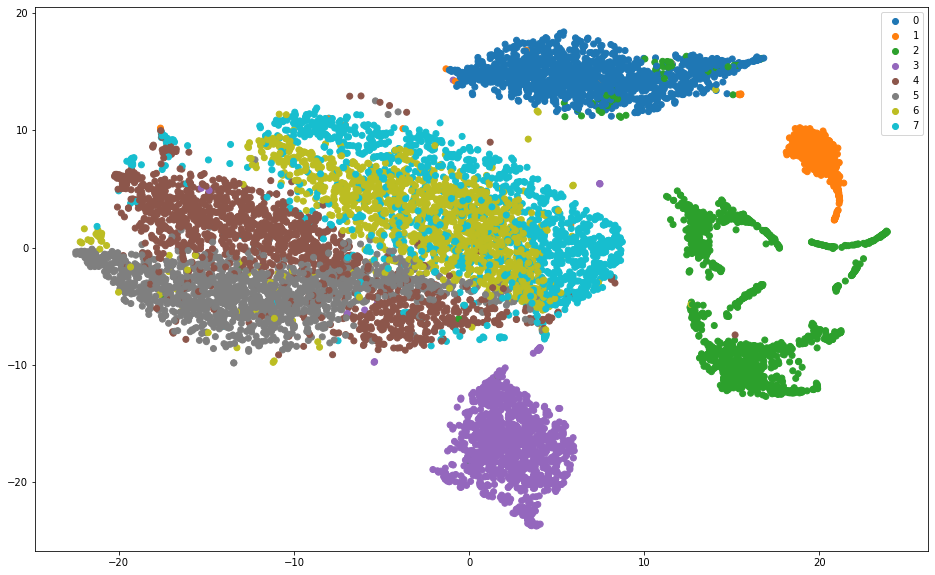

In [ ]:
dataset_labels = [0,1,2,3,4,5,6,7,8,9]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [10]:
def run_experiment(K, dataloader, data_shape, datapoints, labels, epochs=30, hl1_neurons=700, hl2_neurons=200, latent_dimension=10):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=100).fit(datapoints) 
  cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  real_labels = transform_clusters_to_labels(cluster_labels, labels)

  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_silhouette_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  
  for i in range(1):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, cluster_centers, cluster_labels, epochs=epochs)
    latent_data = autoencoder.encoder(datapoints, device)

    data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(latent_data)

    dataset_labels = [0,1,2,3,4,5,6,7,8,9]

    plt.figure(figsize=(16,10))
    scatterplot = plt.scatter(
        x=data_TSNE[:,0], y=data_TSNE[:,1],
        c=labels,
        cmap="tab10"
    )

    handles, _ = scatterplot.legend_elements(prop='colors')
    plt.legend(handles, dataset_labels)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=8, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_hungarian_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(latent_data, kmeans_clusters)
    k_means_silhouette_scores.append(k_means_silhouette_score)

    print("K-means with 8 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)
    print("K-means silhouette score on latent space:", k_means_silhouette_score, "\n")

    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=8).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means silhouette score on latent space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores, k_means_silhouette_scores]

In [ ]:
results_for_k_15 = run_experiment(15, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 15 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.6922
K_means hungarian accuracy score (initial space): 0.6922
Normalised mutual info score (initial space): 0.6048752257657708
ARI (initial space): 0.48815465897444504 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.146603
Epoch: 2/50, Loss: 0.098062
Epoch: 3/50, Loss: 0.029788
Epoch: 4/50, Loss: 0.008240
Epoch: 5/50, Loss: 0.003662
Epoch: 6/50, Loss: 0.002332
Epoch: 7/50, Loss: 0.001844
Epoch: 8/50, Loss: 0.001620
Epoch: 9/50, Loss: 0.001338
Epoch: 10/50, Loss: 0.001181
Epoch: 11/50, Loss: 0.001087
Epoch: 12/50, Loss: 0.001028
Epoch: 13/50, Loss: 0.000989
Epoch: 14/50, Loss: 0.000969
Epoch: 15/50, Loss: 0.000985
Epoch: 16/50, Loss: 0.001066
Epoch: 17/50, Loss: 0.001156
Epoch: 18/50, Loss: 0.000929
Epoch: 19/50, Loss: 0.000828
Epoch: 20/50, Loss: 0.000783
Epoch: 21/50, Loss: 0.000756
Epo

In [ ]:
results_for_k_20 = run_experiment(20, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.7632
K_means hungarian accuracy score (initial space): 0.7632
Normalised mutual info score (initial space): 0.6806227192991489
ARI (initial space): 0.5913674794736083 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.169187
Epoch: 2/50, Loss: 0.108614
Epoch: 3/50, Loss: 0.033223
Epoch: 4/50, Loss: 0.010973
Epoch: 5/50, Loss: 0.005916
Epoch: 6/50, Loss: 0.004305
Epoch: 7/50, Loss: 0.003608
Epoch: 8/50, Loss: 0.003262
Epoch: 9/50, Loss: 0.003058
Epoch: 10/50, Loss: 0.002926
Epoch: 11/50, Loss: 0.002825
Epoch: 12/50, Loss: 0.002718
Epoch: 13/50, Loss: 0.002553
Epoch: 14/50, Loss: 0.002443
Epoch: 15/50, Loss: 0.002360
Epoch: 16/50, Loss: 0.002238
Epoch: 17/50, Loss: 0.002145
Epoch: 18/50, Loss: 0.002046
Epoch: 19/50, Loss: 0.002081
Epoch: 20/50, Loss: 0.002075
Epoch: 21/50, Loss: 0.002010
Epoc

In [ ]:
results_for_k_25 = run_experiment(25, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8269
K_means hungarian accuracy score (initial space): 0.8269
Normalised mutual info score (initial space): 0.7401805108438655
ARI (initial space): 0.6682908728482083 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.156462
Epoch: 2/50, Loss: 0.103720
Epoch: 3/50, Loss: 0.030955
Epoch: 4/50, Loss: 0.008644
Epoch: 5/50, Loss: 0.003851
Epoch: 6/50, Loss: 0.002375
Epoch: 7/50, Loss: 0.001757
Epoch: 8/50, Loss: 0.001442
Epoch: 9/50, Loss: 0.001284
Epoch: 10/50, Loss: 0.001210
Epoch: 11/50, Loss: 0.001179
Epoch: 12/50, Loss: 0.001147
Epoch: 13/50, Loss: 0.001041
Epoch: 14/50, Loss: 0.000944
Epoch: 15/50, Loss: 0.000868
Epoch: 16/50, Loss: 0.000816
Epoch: 17/50, Loss: 0.000782
Epoch: 18/50, Loss: 0.000751
Epoch: 19/50, Loss: 0.000724
Epoch: 20/50, Loss: 0.000702
Epoch: 21/50, Loss: 0.000686
Epoc

In [ ]:
results_for_k_30 = run_experiment(30, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8448
K_means hungarian accuracy score (initial space): 0.8448
Normalised mutual info score (initial space): 0.7641421403742809
ARI (initial space): 0.7036621235197749 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.167738
Epoch: 2/50, Loss: 0.106874
Epoch: 3/50, Loss: 0.035253
Epoch: 4/50, Loss: 0.014459
Epoch: 5/50, Loss: 0.009609
Epoch: 6/50, Loss: 0.007902
Epoch: 7/50, Loss: 0.007198
Epoch: 8/50, Loss: 0.006821
Epoch: 9/50, Loss: 0.006460
Epoch: 10/50, Loss: 0.006140
Epoch: 11/50, Loss: 0.005834
Epoch: 12/50, Loss: 0.005671
Epoch: 13/50, Loss: 0.005594
Epoch: 14/50, Loss: 0.005396
Epoch: 15/50, Loss: 0.005273
Epoch: 16/50, Loss: 0.005046
Epoch: 17/50, Loss: 0.004897
Epoch: 18/50, Loss: 0.004684
Epoch: 19/50, Loss: 0.004586
Epoch: 20/50, Loss: 0.004488
Epoch: 21/50, Loss: 0.004268
Epoc

In [ ]:
results_for_k_35 = run_experiment(35, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 35 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8634
K_means hungarian accuracy score (initial space): 0.8634
Normalised mutual info score (initial space): 0.7803779929932129
ARI (initial space): 0.7289526706326633 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.171571
Epoch: 2/50, Loss: 0.109495
Epoch: 3/50, Loss: 0.033252
Epoch: 4/50, Loss: 0.010307
Epoch: 5/50, Loss: 0.005006
Epoch: 6/50, Loss: 0.003305
Epoch: 7/50, Loss: 0.002583
Epoch: 8/50, Loss: 0.002219
Epoch: 9/50, Loss: 0.002011
Epoch: 10/50, Loss: 0.001881
Epoch: 11/50, Loss: 0.001782
Epoch: 12/50, Loss: 0.001715
Epoch: 13/50, Loss: 0.001665
Epoch: 14/50, Loss: 0.001626
Epoch: 15/50, Loss: 0.001548
Epoch: 16/50, Loss: 0.001450
Epoch: 17/50, Loss: 0.001394
Epoch: 18/50, Loss: 0.001345
Epoch: 19/50, Loss: 0.001284
Epoch: 20/50, Loss: 0.001267
Epoch: 21/50, Loss: 0.001249
Epoc

In [ ]:
results_for_k_40 = run_experiment(40, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9017
K_means hungarian accuracy score (initial space): 0.9017
Normalised mutual info score (initial space): 0.8253670159487181
ARI (initial space): 0.7927436987742664 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.155703
Epoch: 2/50, Loss: 0.103018
Epoch: 3/50, Loss: 0.032115
Epoch: 4/50, Loss: 0.010321
Epoch: 5/50, Loss: 0.005573
Epoch: 6/50, Loss: 0.004057
Epoch: 7/50, Loss: 0.003378
Epoch: 8/50, Loss: 0.002962
Epoch: 9/50, Loss: 0.002710
Epoch: 10/50, Loss: 0.002590
Epoch: 11/50, Loss: 0.002524
Epoch: 12/50, Loss: 0.002389
Epoch: 13/50, Loss: 0.002351
Epoch: 14/50, Loss: 0.002268
Epoch: 15/50, Loss: 0.002176
Epoch: 16/50, Loss: 0.002104
Epoch: 17/50, Loss: 0.002006
Epoch: 18/50, Loss: 0.001933
Epoch: 19/50, Loss: 0.001930
Epoch: 20/50, Loss: 0.001975
Epoch: 21/50, Loss: 0.001957
Epoc

In [ ]:
results_for_k_45 = run_experiment(45, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 45 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8782
K_means hungarian accuracy score (initial space): 0.8782
Normalised mutual info score (initial space): 0.7970620993424703
ARI (initial space): 0.7483515248644551 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.176200
Epoch: 2/50, Loss: 0.112064
Epoch: 3/50, Loss: 0.032758
Epoch: 4/50, Loss: 0.010009
Epoch: 5/50, Loss: 0.004830
Epoch: 6/50, Loss: 0.003126
Epoch: 7/50, Loss: 0.002408
Epoch: 8/50, Loss: 0.002045
Epoch: 9/50, Loss: 0.001837
Epoch: 10/50, Loss: 0.001701
Epoch: 11/50, Loss: 0.001498
Epoch: 12/50, Loss: 0.001401
Epoch: 13/50, Loss: 0.001352
Epoch: 14/50, Loss: 0.001312
Epoch: 15/50, Loss: 0.001265
Epoch: 16/50, Loss: 0.001243
Epoch: 17/50, Loss: 0.001224
Epoch: 18/50, Loss: 0.001206
Epoch: 19/50, Loss: 0.001192
Epoch: 20/50, Loss: 0.001190
Epoch: 21/50, Loss: 0.001166
Epoc

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8889
K_means hungarian accuracy score (initial space): 0.8889
Normalised mutual info score (initial space): 0.8216562462078588
ARI (initial space): 0.7720972038163316 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.160319
Epoch: 2/50, Loss: 0.103053
Epoch: 3/50, Loss: 0.030468
Epoch: 4/50, Loss: 0.009464
Epoch: 5/50, Loss: 0.004849
Epoch: 6/50, Loss: 0.003200
Epoch: 7/50, Loss: 0.002433
Epoch: 8/50, Loss: 0.001994
Epoch: 9/50, Loss: 0.001721
Epoch: 10/50, Loss: 0.001472
Epoch: 11/50, Loss: 0.001290
Epoch: 12/50, Loss: 0.001090
Epoch: 13/50, Loss: 0.001018
Epoch: 14/50, Loss: 0.000921
Epoch: 15/50, Loss: 0.000876
Epoch: 16/50, Loss: 0.000853
Epoch: 17/50, Loss: 0.000845
Epoch: 18/50, Loss: 0.000839
Epoch: 19/50, Loss: 0.000832
Epoch: 20/50, Loss: 0.000815
Epoch: 21/50, Loss: 0.000786
Epoc

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 10000 samples in 0.335s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.116457
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.022842
[t-SNE] KL divergence after 400 iterations: 2.048751
Creating a k-means model on latent data:

K-means with 8 clusters on latent space stats: 

K-means on latent sp

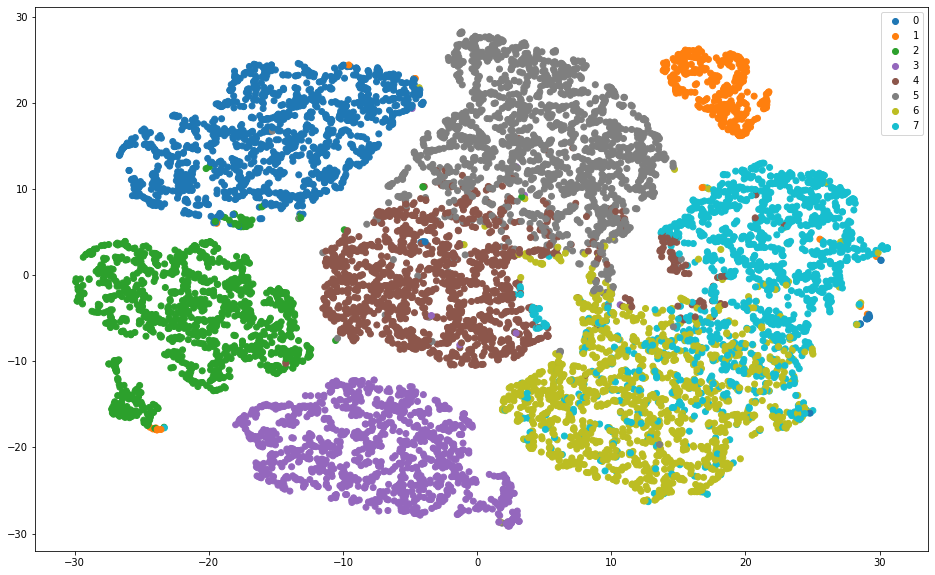

In [11]:
results_for_k_50 = run_experiment(50, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

In [ ]:
results_for_k_55 = run_experiment(55, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.892
K_means hungarian accuracy score (initial space): 0.892
Normalised mutual info score (initial space): 0.8206226866039694
ARI (initial space): 0.7779206084251574 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.143505
Epoch: 2/50, Loss: 0.093171
Epoch: 3/50, Loss: 0.033942
Epoch: 4/50, Loss: 0.015906
Epoch: 5/50, Loss: 0.011508
Epoch: 6/50, Loss: 0.009235
Epoch: 7/50, Loss: 0.007858
Epoch: 8/50, Loss: 0.007084
Epoch: 9/50, Loss: 0.006589
Epoch: 10/50, Loss: 0.005617
Epoch: 11/50, Loss: 0.002799
Epoch: 12/50, Loss: 0.002096
Epoch: 13/50, Loss: 0.001948
Epoch: 14/50, Loss: 0.001869
Epoch: 15/50, Loss: 0.001825
Epoch: 16/50, Loss: 0.001709
Epoch: 17/50, Loss: 0.001625
Epoch: 18/50, Loss: 0.001571
Epoch: 19/50, Loss: 0.001427
Epoch: 20/50, Loss: 0.001365
Epoch: 21/50, Loss: 0.001349
Epoch:

In [ ]:
results_for_k_60 = run_experiment(60, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 60 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9044
K_means hungarian accuracy score (initial space): 0.9044
Normalised mutual info score (initial space): 0.8326057054858585
ARI (initial space): 0.7978635057301638 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.152108
Epoch: 2/50, Loss: 0.101970
Epoch: 3/50, Loss: 0.046037
Epoch: 4/50, Loss: 0.026950
Epoch: 5/50, Loss: 0.022377
Epoch: 6/50, Loss: 0.020684
Epoch: 7/50, Loss: 0.019530
Epoch: 8/50, Loss: 0.018576
Epoch: 9/50, Loss: 0.016409
Epoch: 10/50, Loss: 0.010067
Epoch: 11/50, Loss: 0.002132
Epoch: 12/50, Loss: 0.001378
Epoch: 13/50, Loss: 0.001179
Epoch: 14/50, Loss: 0.001084
Epoch: 15/50, Loss: 0.001026
Epoch: 16/50, Loss: 0.000984
Epoch: 17/50, Loss: 0.000953
Epoch: 18/50, Loss: 0.000928
Epoch: 19/50, Loss: 0.000897
Epoch: 20/50, Loss: 0.000849
Epoch: 21/50, Loss: 0.000807
Epoc

In [ ]:
kmeans_acc = np.zeros((5,10))
kmeans_NMI = np.zeros((5,10))
kmeans_ARI = np.zeros((5,10))
agglo_acc = np.zeros((5,10))
agglo_NMI = np.zeros((5,10))
agglo_ARI = np.zeros((5,10))
kmeans_silhouette = np.zeros((5,10))

for i in range(5):
  
  kmeans_acc[i][0] = results_for_k_15[0][i]
  kmeans_acc[i][1] = results_for_k_20[0][i]
  kmeans_acc[i][2] = results_for_k_25[0][i]
  kmeans_acc[i][3] = results_for_k_30[0][i]
  kmeans_acc[i][4] = results_for_k_35[0][i]
  kmeans_acc[i][5] = results_for_k_40[0][i]
  kmeans_acc[i][6] = results_for_k_45[0][i]
  kmeans_acc[i][7] = results_for_k_50[0][i]
  kmeans_acc[i][8] = results_for_k_55[0][i]
  kmeans_acc[i][9] = results_for_k_60[0][i]

  kmeans_NMI[i][0] = results_for_k_15[1][i]
  kmeans_NMI[i][1] = results_for_k_20[1][i]
  kmeans_NMI[i][2] = results_for_k_25[1][i]
  kmeans_NMI[i][3] = results_for_k_30[1][i]
  kmeans_NMI[i][4] = results_for_k_35[1][i]
  kmeans_NMI[i][5] = results_for_k_40[1][i]
  kmeans_NMI[i][6] = results_for_k_45[1][i]
  kmeans_NMI[i][7] = results_for_k_50[1][i]
  kmeans_NMI[i][8] = results_for_k_55[1][i]
  kmeans_NMI[i][9] = results_for_k_60[1][i]

  kmeans_ARI[i][0] = results_for_k_15[2][i]
  kmeans_ARI[i][1] = results_for_k_20[2][i]
  kmeans_ARI[i][2] = results_for_k_25[2][i]
  kmeans_ARI[i][3] = results_for_k_30[2][i]
  kmeans_ARI[i][4] = results_for_k_35[2][i]
  kmeans_ARI[i][5] = results_for_k_40[2][i]
  kmeans_ARI[i][6] = results_for_k_45[2][i]
  kmeans_ARI[i][7] = results_for_k_50[2][i]
  kmeans_ARI[i][8] = results_for_k_55[2][i]
  kmeans_ARI[i][9] = results_for_k_60[2][i]

  agglo_acc[i][0] = results_for_k_15[3][i]
  agglo_acc[i][1] = results_for_k_20[3][i]
  agglo_acc[i][2] = results_for_k_25[3][i]
  agglo_acc[i][3] = results_for_k_30[3][i]
  agglo_acc[i][4] = results_for_k_35[3][i]
  agglo_acc[i][5] = results_for_k_40[3][i]
  agglo_acc[i][6] = results_for_k_45[3][i]
  agglo_acc[i][7] = results_for_k_50[3][i]
  agglo_acc[i][8] = results_for_k_55[3][i]
  agglo_acc[i][9] = results_for_k_60[3][i]

  agglo_NMI[i][0] = results_for_k_15[4][i]
  agglo_NMI[i][1] = results_for_k_20[4][i]
  agglo_NMI[i][2] = results_for_k_25[4][i]
  agglo_NMI[i][3] = results_for_k_30[4][i]
  agglo_NMI[i][4] = results_for_k_35[4][i]
  agglo_NMI[i][5] = results_for_k_40[4][i]
  agglo_NMI[i][6] = results_for_k_45[4][i]
  agglo_NMI[i][7] = results_for_k_50[4][i]
  agglo_NMI[i][8] = results_for_k_55[4][i]
  agglo_NMI[i][9] = results_for_k_60[4][i]

  agglo_ARI[i][0] = results_for_k_15[5][i]
  agglo_ARI[i][1] = results_for_k_20[5][i]
  agglo_ARI[i][2] = results_for_k_25[5][i]
  agglo_ARI[i][3] = results_for_k_30[5][i]
  agglo_ARI[i][4] = results_for_k_35[5][i]
  agglo_ARI[i][5] = results_for_k_40[5][i]
  agglo_ARI[i][6] = results_for_k_45[5][i]
  agglo_ARI[i][7] = results_for_k_50[5][i]
  agglo_ARI[i][8] = results_for_k_55[5][i]
  agglo_ARI[i][9] = results_for_k_60[5][i]

  kmeans_silhouette[i][0] = results_for_k_15[6][i]
  kmeans_silhouette[i][1] = results_for_k_20[6][i]
  kmeans_silhouette[i][2] = results_for_k_25[6][i]
  kmeans_silhouette[i][3] = results_for_k_30[6][i]
  kmeans_silhouette[i][4] = results_for_k_35[6][i]
  kmeans_silhouette[i][5] = results_for_k_40[6][i]
  kmeans_silhouette[i][6] = results_for_k_45[6][i]
  kmeans_silhouette[i][7] = results_for_k_50[6][i]
  kmeans_silhouette[i][8] = results_for_k_55[6][i]
  kmeans_silhouette[i][9] = results_for_k_60[6][i]


Text(0.5, 0, 'K')

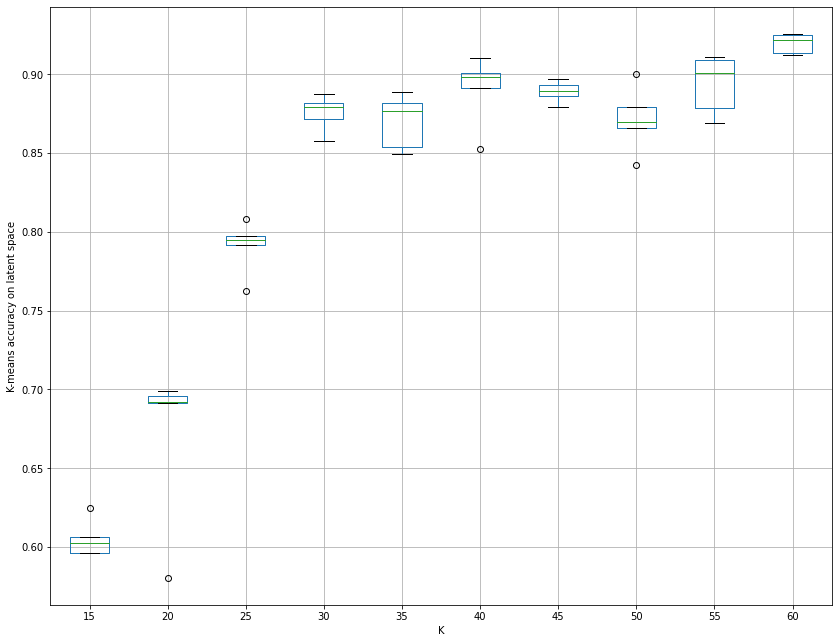

In [ ]:
columns = ['15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

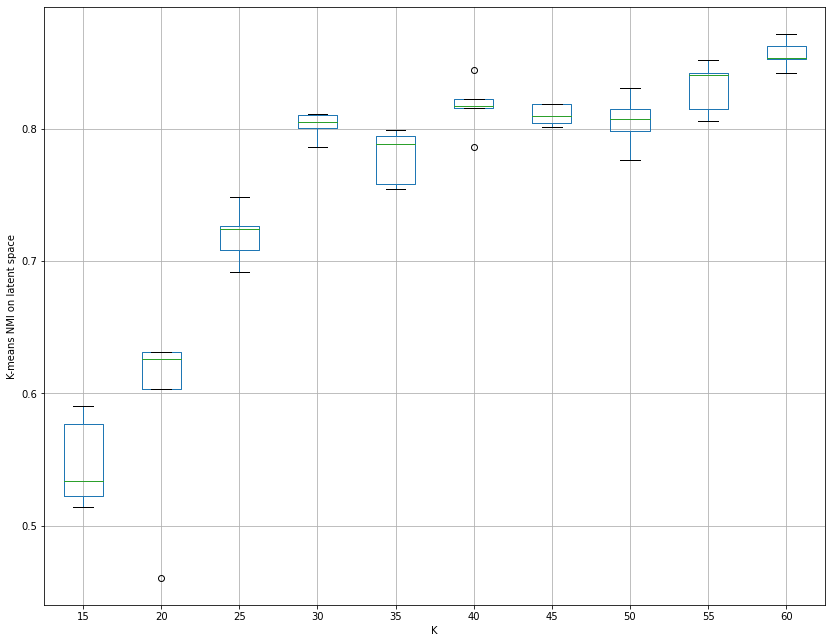

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

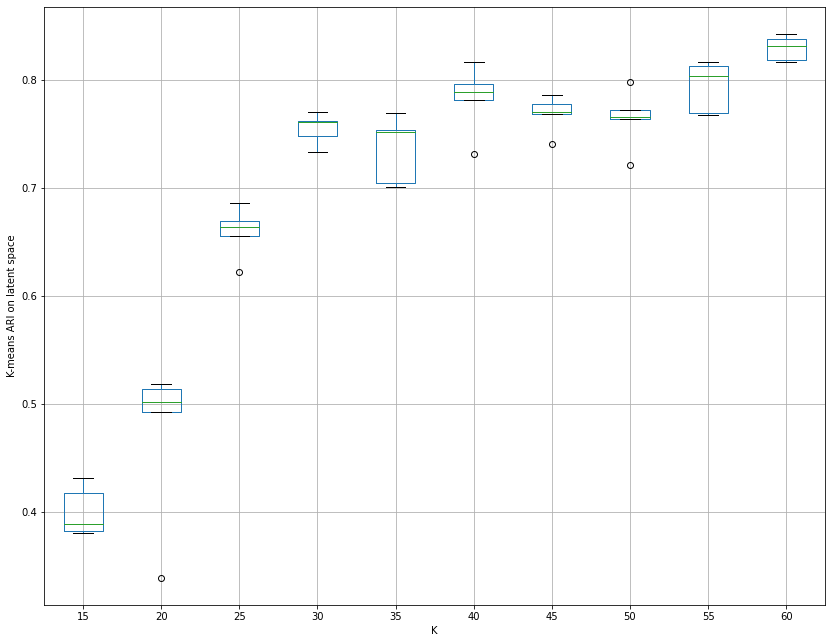

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

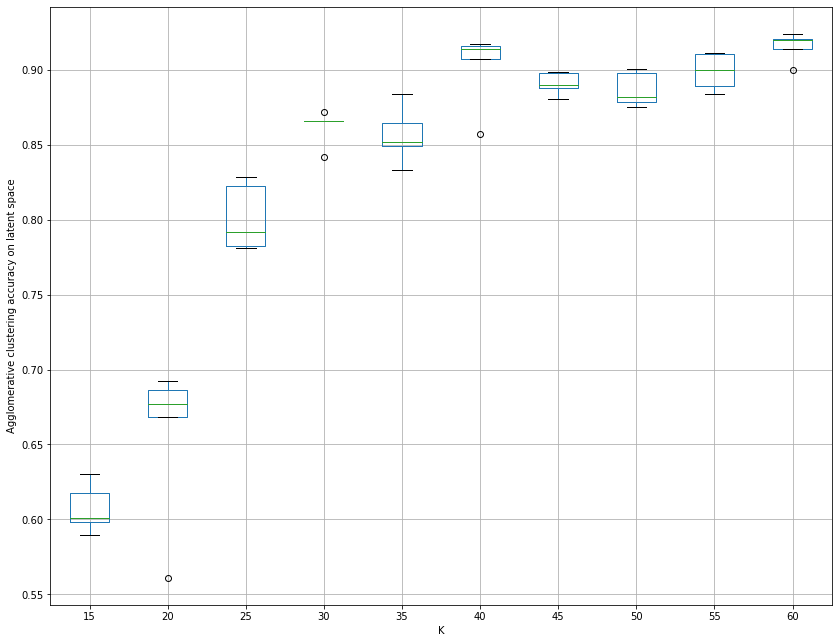

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

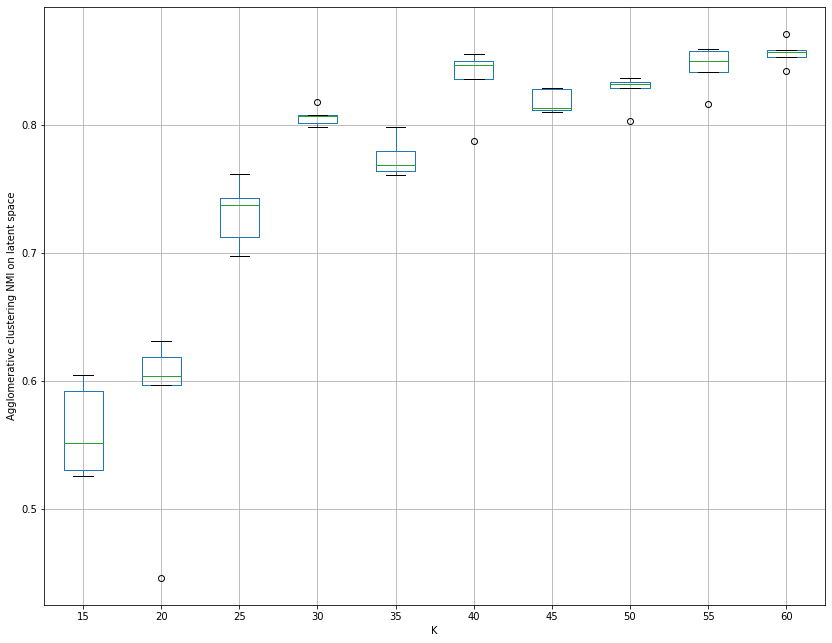

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

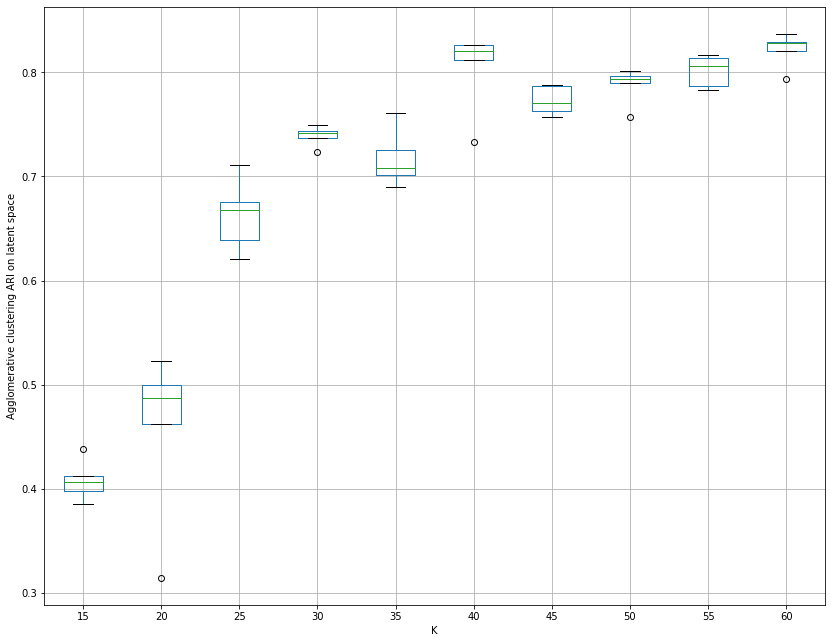

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

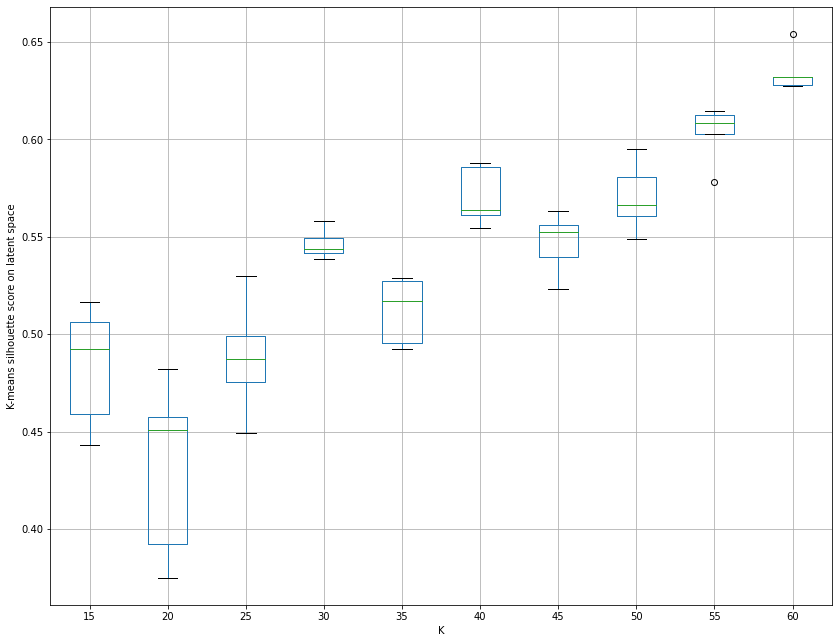

In [ ]:
df = pd.DataFrame(kmeans_silhouette,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means silhouette score on latent space')
boxplot.set_xlabel('K')

# Silhoutte factor

In [ ]:
def get_all_representations(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers):

  representation_K_tuples = []

  for K in list_of_cluster_numbers:
    print("Creating representation for K =", K, ":\n")
    print("Running k-means...\n")
    kmeans = KMeans(n_clusters=K, n_init=100).fit(datapoints)
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_

    # using the autoencoder model on our data

    print("Training autoencoder...\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, cluster_centers, cluster_labels, epochs=epochs)
    print("\n")
    latent_data = autoencoder.encoder(datapoints, device)
    r = latent_data

    representation_K_tuples.append((r,K))

  return representation_K_tuples


In [ ]:
def calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers):
  representations = [pair[0] for pair in representation_tuples]
  rep_silhouette_list = [[] for i in range(len(representations))]

  for index, rep in enumerate(representations):
    print("Starting process for representation number", index + 1,":\n")
    for K in list_of_cluster_numbers:
      print("Running kmeans for K =", K,"...")
      kmeans = KMeans(n_clusters=K, n_init=100).fit(rep)
      k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
      rep_silhouette_list[index].append(k_means_silhouette_score)
    print("\n")

  return rep_silhouette_list

In [ ]:
def get_max_silhouette_for_each_representation(rep_silhouette_lst):
  max_silhouette_tuples = [] # keep tuples in the form of (index, max_silhouette)

  for index, silhouette_lst in enumerate(rep_silhouette_lst):
    max = silhouette_lst[0]

    for i in range(1,len(silhouette_lst)):
        if silhouette_lst[i] > max:
            max = silhouette_lst[i]

    max_silhouette_tuples.append((index, max))

  return max_silhouette_tuples

In [ ]:
def calculate_representation_kmeans_acc(representation_tuples, Y):
  representations = [pair[0] for pair in representation_tuples]
  accuracies = []

  for index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=8, n_init=100).fit(rep)
    kmeans_clusters = kmeans.labels_
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, Y)
    acc = accuracy_score(Y, kmeans_greedy_labels)
    accuracies.append((index,acc))

  return accuracies

In [ ]:
def calculate_normalised_silhouette(max_silhouette_tuples, representation_tuples):
  normalised_silhouette_tuples = []
  representations = [pair[0] for pair in representation_tuples]

  for rep_index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=8, n_init=100).fit(rep)
    k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
    normalised_silhouette = (k_means_silhouette_score) / (max_silhouette_tuples[rep_index][1])
    normalised_silhouette_tuples.append((rep_index, normalised_silhouette))


  return normalised_silhouette_tuples

In [ ]:
def silhouette_factor(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers):
  representation_tuples = get_all_representations(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers)
  representation_silhouette_list = calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers)
  max_silhouette_list = get_max_silhouette_for_each_representation(representation_silhouette_list)
  normalised_silhouette_scores = calculate_normalised_silhouette(max_silhouette_list,representation_tuples)
  k_means_accuracies = calculate_representation_kmeans_acc(representation_tuples, labels)
  print(normalised_silhouette_scores)
  print(k_means_accuracies)

  return normalised_silhouette_scores, k_means_accuracies 

In [ ]:
normalised_silhouette_scores, k_means_accuracies = silhouette_factor(dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8, list_of_cluster_numbers=[15,20,25,30,35,40,45,50,55,60])

Creating representation for K = 15 :

Running k-means...

Training autoencoder...

Epoch: 1/50, Loss: 0.167973
Epoch: 2/50, Loss: 0.107002
Epoch: 3/50, Loss: 0.039233
Epoch: 4/50, Loss: 0.016555
Epoch: 5/50, Loss: 0.011155
Epoch: 6/50, Loss: 0.009058
Epoch: 7/50, Loss: 0.007863
Epoch: 8/50, Loss: 0.007098
Epoch: 9/50, Loss: 0.006709
Epoch: 10/50, Loss: 0.006108
Epoch: 11/50, Loss: 0.005400
Epoch: 12/50, Loss: 0.002387
Epoch: 13/50, Loss: 0.001550
Epoch: 14/50, Loss: 0.001129
Epoch: 15/50, Loss: 0.000753
Epoch: 16/50, Loss: 0.000661
Epoch: 17/50, Loss: 0.000619
Epoch: 18/50, Loss: 0.000591
Epoch: 19/50, Loss: 0.000570
Epoch: 20/50, Loss: 0.000554
Epoch: 21/50, Loss: 0.000544
Epoch: 22/50, Loss: 0.000558
Epoch: 23/50, Loss: 0.000599
Epoch: 24/50, Loss: 0.000550
Epoch: 25/50, Loss: 0.000518
Epoch: 26/50, Loss: 0.000496
Epoch: 27/50, Loss: 0.000478
Epoch: 28/50, Loss: 0.000463
Epoch: 29/50, Loss: 0.000449
Epoch: 30/50, Loss: 0.000436
Epoch: 31/50, Loss: 0.000427
Epoch: 32/50, Loss: 0.00042

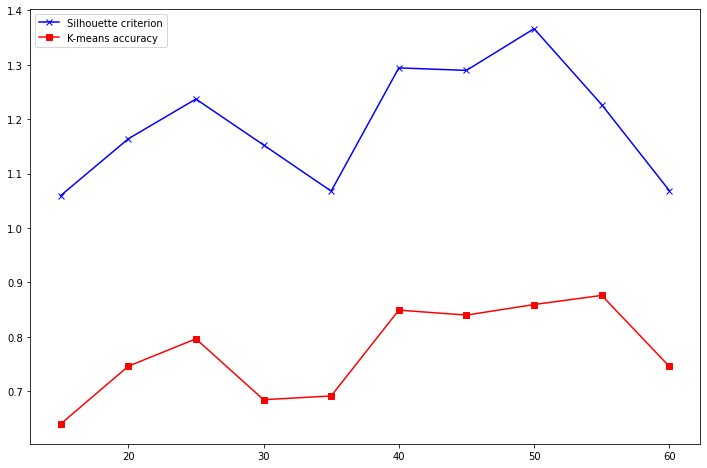

In [ ]:
list_of_cluster_numbers= [15,20,25,30,35,40,45,50,55,60]

normalised_silhouette_scores = [t[1] for t in normalised_silhouette_scores]
k_means_accuracies = [t[1] for t in k_means_accuracies]

plt.figure(figsize=(12, 8))
plt.plot(list_of_cluster_numbers, normalised_silhouette_scores, c='b', marker='x', label='Silhouette criterion')
plt.plot(list_of_cluster_numbers, k_means_accuracies, c='r', marker='s', label='K-means accuracy')
plt.legend(loc='upper left')
plt.show()